# 📚 Chapter 7: Unsupervised Learning: Repurposing Drugs, Curating Compounds, & Screening Fragments

*This notebook contains the code examples in chapter 7. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH07_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- Key methods in unsupervised learning
- Application of dimensionality reduction for drug repurposing
- Clustering to facilitate the design of diverse and focused compound libraries
- How to leverage density estimation for pharmacophore modeling
- The fragment-based drug design paradigm

## ⚙️ Part 0: Installation and Setup

**❗️NOTE:** After setting up a local environment, install the required packages via:
`!pip install -r https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/requirements.txt --quiet`

**❗️NOTE:** If running notebook via Colab, be sure to install RDKit via: `!pip install rdkit`

### Import and Setup Packages 

In [1]:
import itertools, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap

from minisom import MiniSom
from scipy.optimize import curve_fit
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from rdkit import Chem
from rdkit.Chem import AllChem

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF", "#21130d"]
sns.set_palette(sns.color_palette(colors))

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1️⃣ Dimensionality Reduction: Drug Repurposing

We load the COVID Moonshot data set, compute Morgan fingerprints (2048 bits, radius 2), and define labels based on literature precedence. The approaches we discuss throughout this chapter pertain to unsupervised learning, which doesn’t require labels. We compute these optional active and inactive labels to facilitate additional analysis.

In [188]:
# Load the data
file_path = 'CH07/data/raw/CH07_activity_data.csv'
data = pd.read_csv(file_path)

def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return np.nan

data['Morgan_Fingerprint'] = data['SMILES'].apply(generate_morgan_fingerprint)

data = data.dropna(subset=['Morgan_Fingerprint'])

data["label"] = np.where(
    data['f_avg_IC50']>=5, 1, np.where(
        data['f_avg_IC50']<5, 2, 3 
    )
)

# Convert the fingerprints to a numpy array
fingerprints = np.array([list(fp) for fp in data['Morgan_Fingerprint']])
label_names = {1:'Active', 2:'Inactive', 3:'Unknown'}

# Save the fingerprints and original data
np.save('CH07/data/processed/morgan_fingerprints.npy', fingerprints)
data.to_csv('CH07/data/processed/processed_CH07_activity_data.csv', index=False)

In [177]:
data = pd.read_csv('CH07/data/processed/processed_CH07_activity_data.csv')
fingerprints = np.load('CH07/data/processed/morgan_fingerprints.npy')

### High Throughput Screening Data

**Code for Figure 7.2.** Example of a dose response curve on arbitrary data.

Fitted parameters:
E_max: 93.3845345193496
IC50: 0.07799836454253202
Hill coefficient (n): 0.6707229453125185


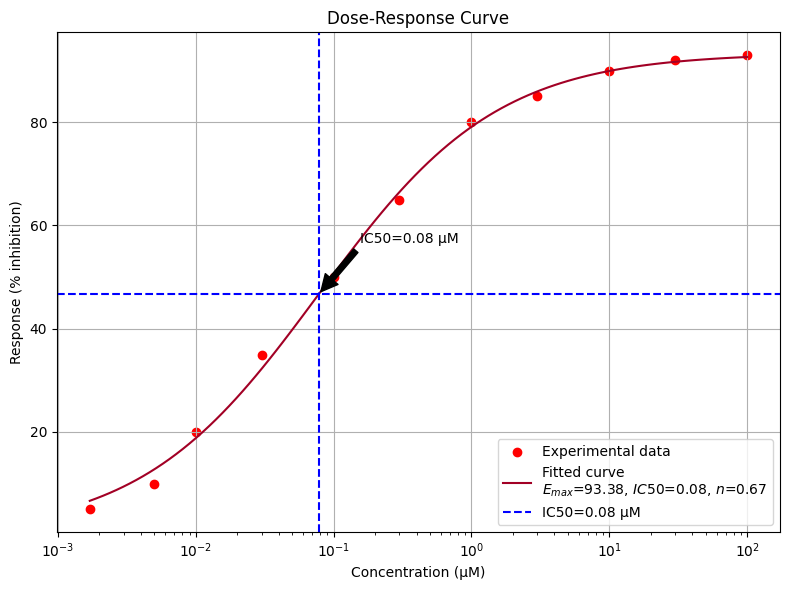

In [239]:
# Example dose-response data
concentrations = np.array([0.0017, 0.005, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])  # in µM
responses = np.array([5, 10, 20, 35, 50, 65, 80, 85, 90, 92, 93])  # arbitrary units, % inhibition for example

# Hill equation function
def hill_equation(conc, E_max, IC50, n):
    return E_max * conc**n / (IC50**n + conc**n)

# Initial guesses for E_max, IC50, and Hill coefficient (n)
initial_guesses = [100, 1, 1]

# Constraints: E_max between 0 and 100, IC50 between 0 and 100, n between 0.1 and 3
param_bounds = ([0, 0, 0.1], [100, 100, 3])

# Fit the Hill equation to the data using the Levenberg-Marquardt algorithm
popt, pcov = curve_fit(hill_equation, concentrations, responses, p0=initial_guesses, bounds=param_bounds, method='trf')

# Extract the optimal parameters
E_max_opt, IC50_opt, n_opt = popt

# Generate data for the fitted curve, then plot it
concentration_range = np.logspace(np.log10(concentrations.min()), np.log10(concentrations.max()), 100)
fitted_responses = hill_equation(concentration_range, *popt)

plt.figure(figsize=(8, 6))
plt.scatter(concentrations, responses, color='red', label='Experimental data')
plt.plot(concentration_range, fitted_responses, label=f'Fitted curve\n$E_{{max}}$={E_max_opt:.2f}, $IC50$={IC50_opt:.2f}, $n$={n_opt:.2f}')
plt.xscale('log')
plt.xlabel('Concentration (µM)')
plt.ylabel('Response (% inhibition)')
plt.title('Dose-Response Curve')
plt.legend()
plt.grid(True)

# Annotate the IC50 value and the "measurement" points on the plot
ic50_response = hill_equation(IC50_opt, E_max_opt, IC50_opt, n_opt)
plt.axhline(y=ic50_response, color='blue', linestyle='--', label=f'IC50={IC50_opt:.2f} µM')
plt.axvline(x=IC50_opt, color='blue', linestyle='--')
plt.annotate(f'IC50={IC50_opt:.2f} µM', 
             xy=(IC50_opt, ic50_response), 
             xytext=(IC50_opt*2, ic50_response+10),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.tight_layout()
plt.savefig('figures/ch07/fitted_dose_response_curve.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/fitted_dose_response_curve.pdf', bbox_inches='tight', dpi=600);

print(f"Fitted parameters:\nE_max: {E_max_opt}\nIC50: {IC50_opt}\nHill coefficient (n): {n_opt}")


### Self-Organizing Maps

**Code for Figure 7.3.** Over many iterations of node updates, the grid will self-organize such that similar nodes are close together and dissimilar nodes are far apart. Though we visualize the grid as 2D, each node is described by its own vector, so it really exists in 3D.

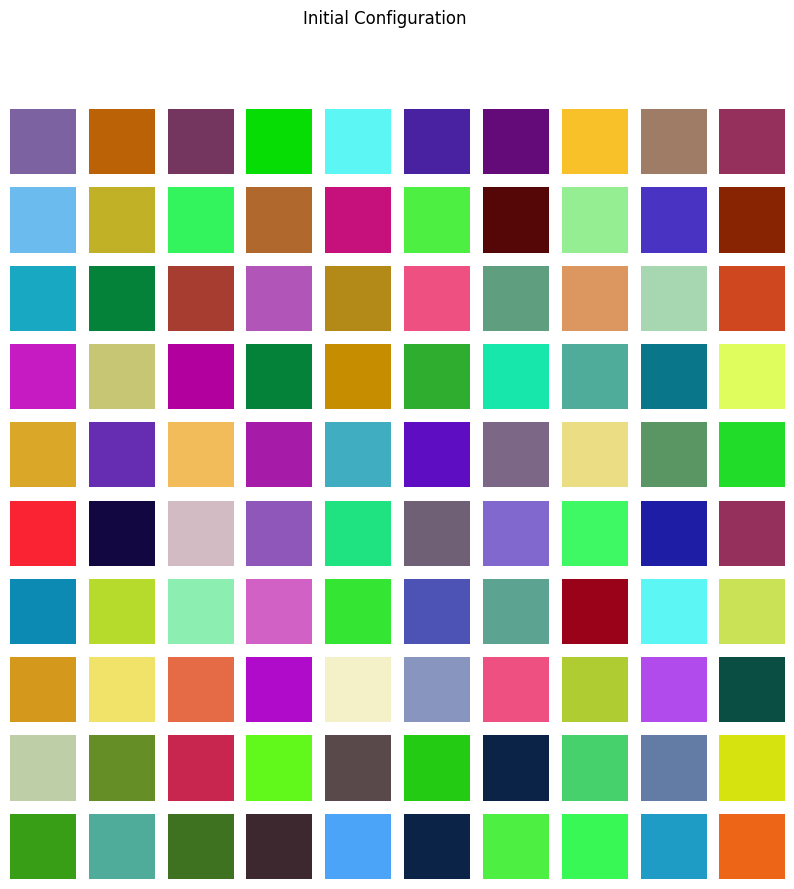

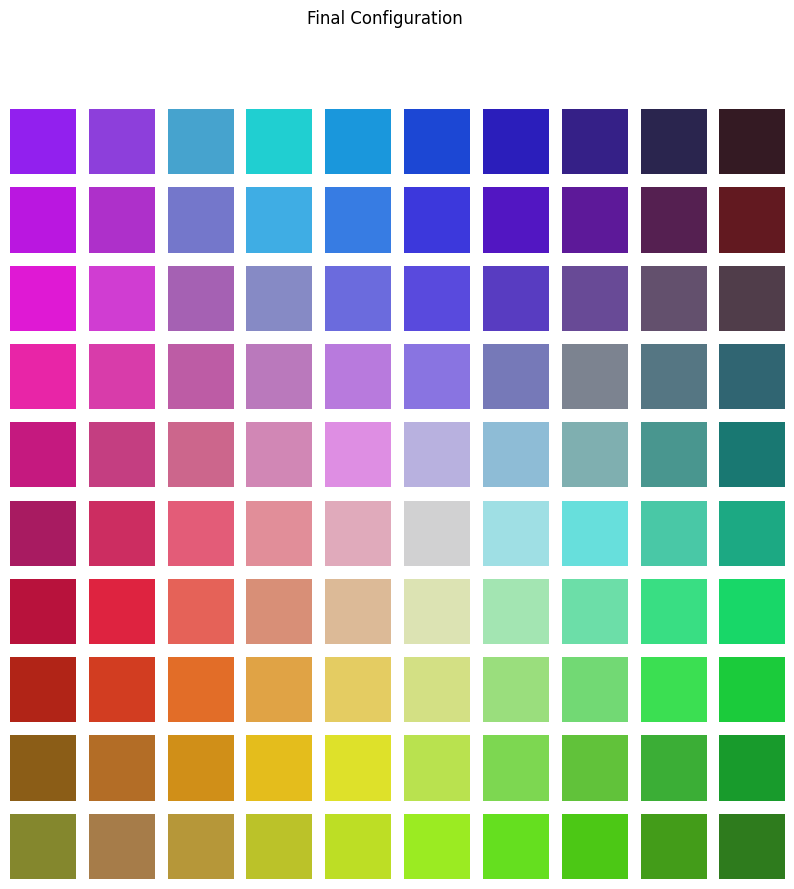

In [ ]:
# Generate 100 random colors
np.random.seed(42)
colors = np.random.rand(1000, 3)  # 100 colors with RGB components

# Create and train the SOM
som = MiniSom(x=10, y=10, input_len=3, sigma=1.5, learning_rate=0.5, random_seed=RANDOM_SEED)
som.random_weights_init(colors)
initial_weights = som.get_weights().copy()
som.train_random(colors, 2000)

def plot_colors(colors, title):
    plt.figure(figsize=(10, 10))
    for i, color in enumerate(colors):
        plt.subplot(10, 10, i+1)
        plt.imshow([[color]])
        plt.axis('off')
    plt.suptitle(title)

# Visualize initial configuration
plot_colors(initial_weights.reshape(100, 3), 'Initial Configuration')

# Get the final weights from the trained SOM and visualize
final_weights = som.get_weights()
plot_colors(final_weights.reshape(100, 3), 'Final Configuration')

**Train and evaluate (cross-validation) SOM**

In [87]:
fingerprints_train, fingerprints_test = train_test_split(fingerprints, test_size=0.2)

base_settings = {
    'x': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'y': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'input_len': fingerprints.shape[1],
    'neighborhood_function': 'gaussian',
    'random_seed': RANDOM_SEED,
    'topology': 'rectangular',
}

som_param_grid = {
    'sigma': [0.5, 1, 1.5, 2, 3, 5],
    'learning_rate': [0.5, 1],
    'activation_distance': ['euclidean', 'cosine']  # Can also pass in custom, callable distance function 
}

best_setting = (None, np.inf)
for values in itertools.product(*som_param_grid.values()):
    point = dict(zip(som_param_grid.keys(), values))
    # merge the general settings

    som = MiniSom(**base_settings, **point)
    som.train(fingerprints_train, 5000)

    topographic_error = som.topographic_error(fingerprints_test)
    quantization_error = som.quantization_error(fingerprints_test)

    print(f"Current Parameters: {point}\nTopographic Error: {topographic_error}\nQuantization Error: {quantization_error}")
    if topographic_error < best_setting[1]:
        best_setting = ({**base_settings, **point}, topographic_error)

print(f"Best Parameter Setting: {best_setting[0]}\nError: {best_setting[1]}")

Current Parameters: {'sigma': 0.5, 'learning_rate': 0.5, 'activation_distance': 'euclidean'}
Topographic Error: 0.6416464891041163
Quantization Error: 4.630557767486479
Current Parameters: {'sigma': 0.5, 'learning_rate': 0.5, 'activation_distance': 'cosine'}
Topographic Error: 0.5569007263922519
Quantization Error: 4.6136724092967665
Current Parameters: {'sigma': 0.5, 'learning_rate': 1, 'activation_distance': 'euclidean'}
Topographic Error: 0.6803874092009685
Quantization Error: 4.628382189071244
Current Parameters: {'sigma': 0.5, 'learning_rate': 1, 'activation_distance': 'cosine'}
Topographic Error: 0.6343825665859564
Quantization Error: 4.959875049312923
Current Parameters: {'sigma': 1, 'learning_rate': 0.5, 'activation_distance': 'euclidean'}
Topographic Error: 0.23728813559322035
Quantization Error: 4.167309473385919
Current Parameters: {'sigma': 1, 'learning_rate': 0.5, 'activation_distance': 'cosine'}
Topographic Error: 0.24939467312348668
Quantization Error: 4.139816875005099


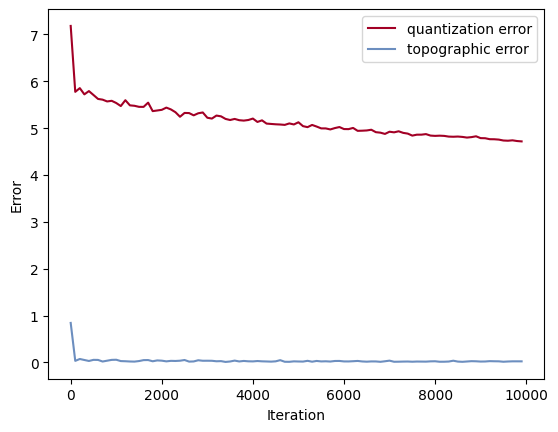

In [91]:
n_nodes = 16
m_nodes = 16
som = MiniSom(n_nodes, m_nodes, fingerprints.shape[1], sigma=5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=RANDOM_SEED, topology='rectangular',
              activation_distance='cosine')

max_iter = 10000
iter, q_error, t_error = [], [], []

for i in range(max_iter):
    rand_i = np.random.randint(len(fingerprints))
    som.update(fingerprints[rand_i], som.winner(fingerprints[rand_i]), i, max_iter)
    if i % 100 == 0:
        iter.append(i)
        q_error.append(som.quantization_error(fingerprints))
        t_error.append(som.topographic_error(fingerprints))

plt.plot(iter, q_error, label='quantization error')
plt.plot(iter, t_error, label='topographic error')
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.legend()

In [161]:
n_nodes = 16
m_nodes = 16
som = MiniSom(n_nodes, m_nodes, fingerprints.shape[1], sigma=5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=RANDOM_SEED, topology='rectangular',
              activation_distance='cosine')
som.train(fingerprints, 5000)

**Code for Figure 7.4.** (Left) Visualize the proportion of compounds per class that reside in a specific node. We observe that nodes in the top right and top left quadrants are most enriched for active and inactive compounds, respectively. (Right) . The UMAT represents the average distance between a node and its neighbors by color: areas with lighter colors (lower values) indicate that the nodes are close to each other, suggesting a cluster of similar data points that preserves the topology of the high-dimensional training data.

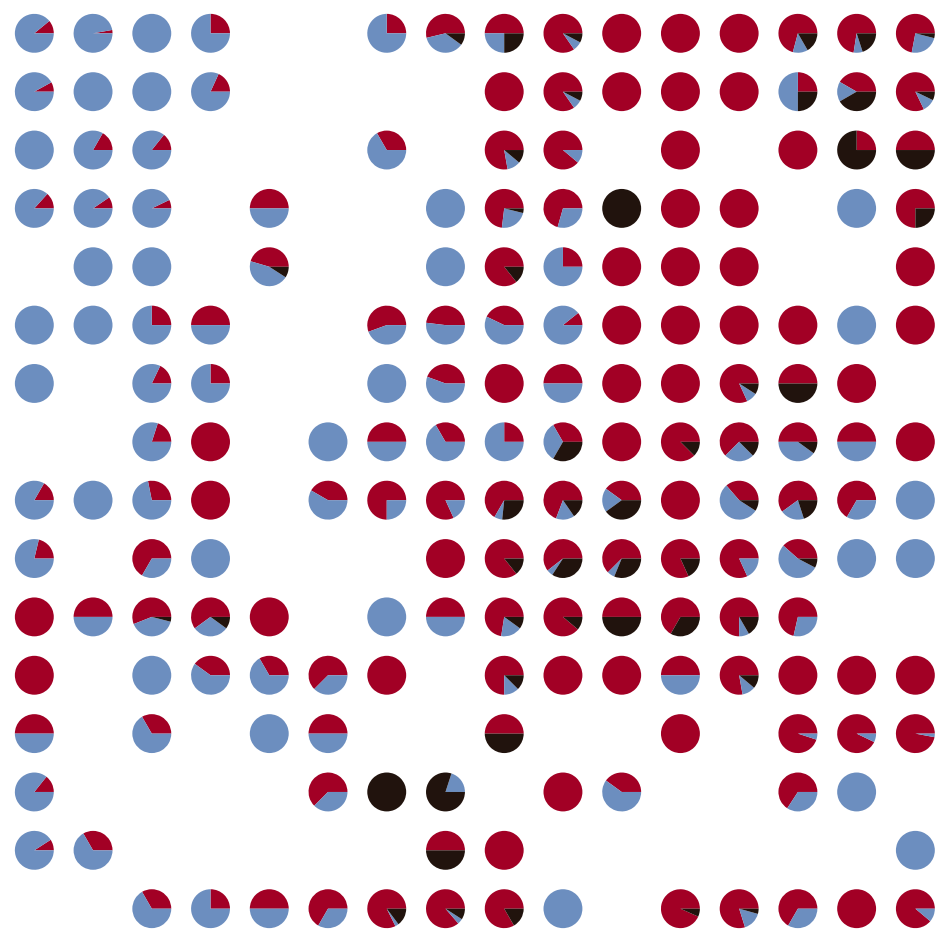

In [117]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(fingerprints, [label_names[t] for t in target])
target = data['label'].values
colors = ["#A20025", "#6C8EBF", "#21130d"]

fig = plt.figure(figsize=(12, 12))
the_grid = gridspec.GridSpec(n_nodes, m_nodes, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_nodes-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

In [106]:
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go

# Adapted from https://github.com/JustGlowing/minisom/blob/master/examples/AdvancedVisualization.ipynb
def findMin(x, y, umat):
    newxmin=max(0,x-1)
    newxmax=min(umat.shape[0],x+2)
    newymin=max(0,y-1)
    newymax=min(umat.shape[1],y+2)
    minx, miny = np.where(umat[newxmin:newxmax,newymin:newymax] == umat[newxmin:newxmax,newymin:newymax].min())
    return newxmin+minx[0], newymin+miny[0]

def findInternalNode(x, y, umat):
    minx, miny = findMin(x,y,umat)
    if (minx == x and miny == y):
        cx = minx
        cy = miny
    else:
        cx,cy = findInternalNode(minx,miny,umat)
    return cx, cy

def matplotlib_cmap_to_plotly(cmap, entries):
    h = 1.0/(entries-1)
    colorscale = []

    for k in range(entries):
        C = (np.array(cmap(k*h)[:3])*255)
        colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return colorscale

def plotStarburstMap(som):
    boner_rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    bone_r_cmap = matplotlib.cm.get_cmap('bone_r')

    bone_r = matplotlib_cmap_to_plotly(bone_r_cmap, 255)

    layout = go.Layout()
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Heatmap(z=som.distance_map().T, colorscale=bone_r))
    shapes=[]

    for row in np.arange(som.distance_map().shape[0]):
        for col in np.arange(som.distance_map().shape[1]):
            cx,cy = findInternalNode(row, col, som.distance_map().T)
            shape=go.layout.Shape(
                    type="line",
                    x0=row,
                    y0=col,
                    x1=cx,
                    y1=cy,
                    line=dict(
                        color="Black",
                        width=1
                    )
                )
            shapes=np.append(shapes, shape)

    fig.update_layout(shapes=shapes.tolist(), 
        width=500,
        height=500) 
    fig.show()
    
plotStarburstMap(som)

/tmp/ipykernel_119/2067260042.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



### Drug Repurposing

In [181]:
# Load the data
file_path = 'CH07/data/raw/CH07_drug_repurposing_hub.csv'
drh_data = pd.read_csv(file_path)

In [182]:
retrospective_hits = set([
    'atpenin a5', 'tinostamustine', 'chloroquine', 'hydroxychloroquine',
    'remdesivir', 'favipiravir', 'ribavirin', 'oseltamivir', 'umifenovir',
    'lopinavir', 'ritonavir', 'ivermectin', 'bananins', 'nafamostat',
    'imatinib', 'corticosteroid', 'baricitinib', 'azithromycin', 'losartan',
    'telmisartan', 'nelfinavir', 'prulifloxacin', 'tegobuvir', 'bictegravir'
])
drh_compounds = set(drh_data['pert_iname'].tolist())
retrospective_hits_in_drh = [x for ele in drh_compounds for x in retrospective_hits if x == ele]

In [185]:
retrospective_hits_in_drh

['prulifloxacin',
 'chloroquine',
 'tinostamustine',
 'nelfinavir',
 'ivermectin',
 'lopinavir',
 'nafamostat',
 'ritonavir',
 'losartan',
 'telmisartan',
 'ribavirin',
 'favipiravir',
 'tegobuvir',
 'bictegravir',
 'azithromycin',
 'baricitinib',
 'imatinib',
 'atpenin a5',
 'hydroxychloroquine']

In [179]:
# Label each SOM node based on majority label of the training data points mapped to that node
def majority_label(labels):
    return np.argmax(np.bincount(labels))

win_map = som.win_map(fingerprints, return_indices=True)
node_labels = {}
for position, instances in win_map.items():
    instance_labels = [data['label'].iloc[idx] for idx in instances]
    node_labels[position] = majority_label(instance_labels)

In [186]:
drh_data = drh_data.dropna()

In [189]:
drh_data = drh_data.dropna()
drh_data['Morgan_Fingerprint'] = drh_data['smiles'].apply(generate_morgan_fingerprint)
drh_data = drh_data.dropna(subset=['Morgan_Fingerprint'])
unseen_fingerprints = np.array([list(fp) for fp in drh_data['Morgan_Fingerprint']])

In [190]:
# Predict activity of unseen molecules
predicted_activities = []
for fingerprint in unseen_fingerprints:
    winner_node = som.winner(fingerprint)
    predicted_activity = node_labels.get(winner_node, None)  # If node is not labeled, return None
    predicted_activities.append(predicted_activity)

# Output the results
drh_data['predicted_labels'] = predicted_activities
drh_data['predicted_activities'] = drh_data.predicted_labels.map(label_names.get)

/tmp/ipykernel_119/3880349036.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
predicted_drh_hits = set(drh_data[drh_data['predicted_activities'] == 'Active']['pert_iname'].tolist())
retrospective_hits_in_drh = [x for ele in drh_compounds for x in retrospective_hits if x == ele]
captured_drh_hits = [x for ele in predicted_drh_hits for x in retrospective_hits_in_drh if x == ele]

In [ ]:
print(f"Success Rate: {len(captured_drh_hits)/len(retrospective_hits_in_drh)}")

In [216]:
sorted(captured_drh_hits)

['atpenin a5',
 'azithromycin',
 'baricitinib',
 'bictegravir',
 'chloroquine',
 'favipiravir',
 'hydroxychloroquine',
 'imatinib',
 'ivermectin',
 'lopinavir',
 'losartan',
 'nafamostat',
 'nelfinavir',
 'prulifloxacin',
 'ribavirin',
 'tegobuvir',
 'telmisartan',
 'tinostamustine']

In [212]:
retrospective_hits_in_drh

['chloroquine',
 'lopinavir',
 'nafamostat',
 'prulifloxacin',
 'imatinib',
 'atpenin a5',
 'favipiravir',
 'bictegravir',
 'baricitinib',
 'tinostamustine',
 'tegobuvir',
 'azithromycin',
 'telmisartan',
 'ritonavir',
 'ribavirin',
 'ivermectin',
 'hydroxychloroquine',
 'losartan',
 'nelfinavir']

In [193]:
drh_data['predicted_activities'].value_counts()

Active      6345
Unknown      136
Inactive     103
Name: predicted_activities, dtype: int64

In [196]:
data['label'].value_counts()

1    1144
2     782
3     136
Name: label, dtype: int64

### Universal Manifold Approximation & Projection (UMAP)

**Code for Figure 7.5.** Comparison of PCA to a more complex manifold learning algorithm on the Swiss Roll data set.

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


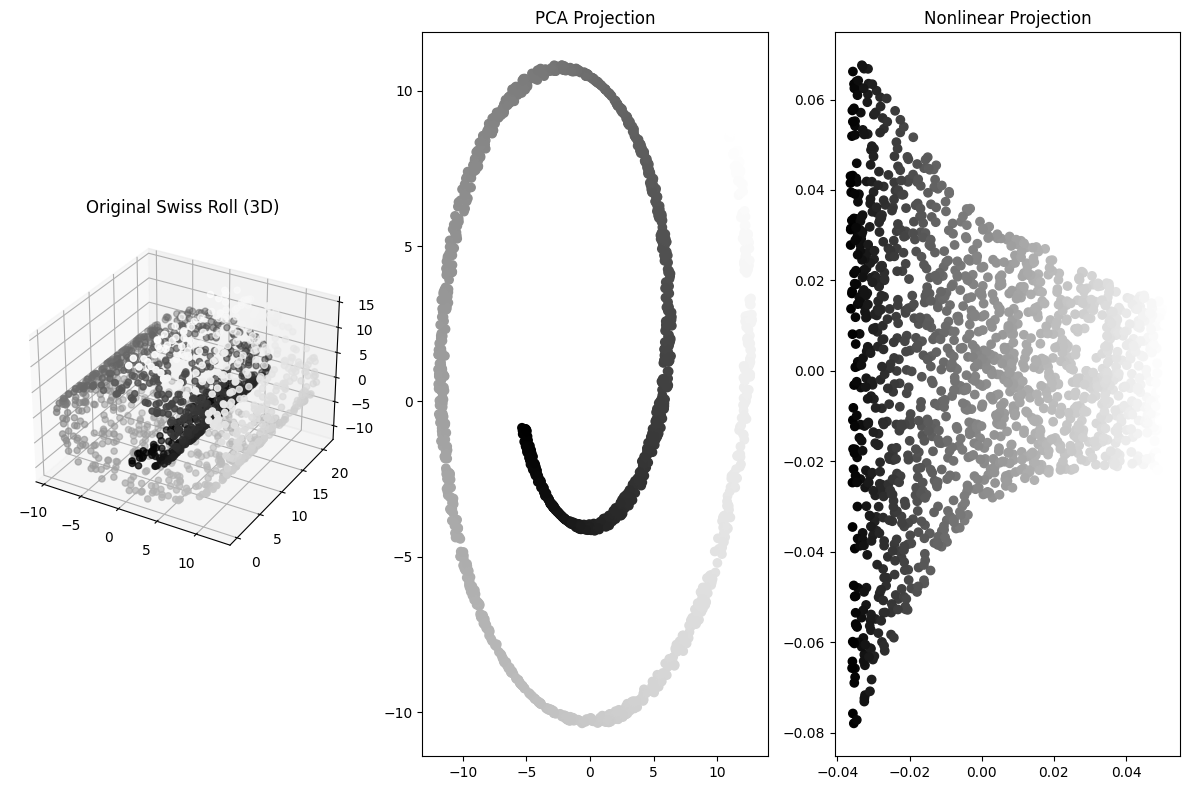

In [3]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import locally_linear_embedding

n_samples = 1500
X, color = make_swiss_roll(n_samples=n_samples, random_state=RANDOM_SEED)
grayscale = (color - color.min()) / (color.max() - color.min())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(X)

X_lle, _ = locally_linear_embedding(
    X, n_neighbors=12, n_components=2
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=grayscale, cmap='gray')
ax.set_title("Original Swiss Roll (3D)")

ax = fig.add_subplot(132)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=grayscale, cmap='gray')
ax.set_title("PCA Projection")

ax = fig.add_subplot(133)
scatter = ax.scatter(X_lle[:, 0], X_lle[:, 1], c=grayscale, cmap='gray')
ax.set_title("Nonlinear Projection")

plt.tight_layout()
plt.savefig('figures/ch07/swiss_roll_visual.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/swiss_roll_visual.pdf', bbox_inches='tight', dpi=600);

In [192]:
drh_data = drh_data[["pert_iname", "Morgan_Fingerprint"]]
drh_data["retro_hit"] = drh_data.pert_iname.isin(set(retrospective_hits_in_drh))

In [228]:
train_labels = (data["label"] == 1).values
test_labels = drh_data["retro_hit"].values
train_fps = fingerprints
test_fps = unseen_fingerprints

umap_params = {
    'umap__n_neighbors': [5, 10, 15],
    'umap__min_dist': [0.1, 0.2, 0.3]
}
pipeline = Pipeline([
    ('umap', umap.UMAP(metric="jaccard", n_components=2)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
])

param_grid = {**umap_params}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_micro', n_jobs=-1)
grid_search.fit(train_fps, train_labels)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Train the model with the best parameters on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(train_fps, train_labels)


/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarni

Best parameters: {'umap__min_dist': 0.2, 'umap__n_neighbors': 10}
Best cross-validation score: 0.6425264886090519


/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


Pipeline(steps=[('umap',
                 UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.2, n_neighbors=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('knn', KNeighborsClassifier())])

**Code for Figure 7.7.** UMAP projection across each COVID Moonshot compound’s activity (left) and chemical series designation (right).

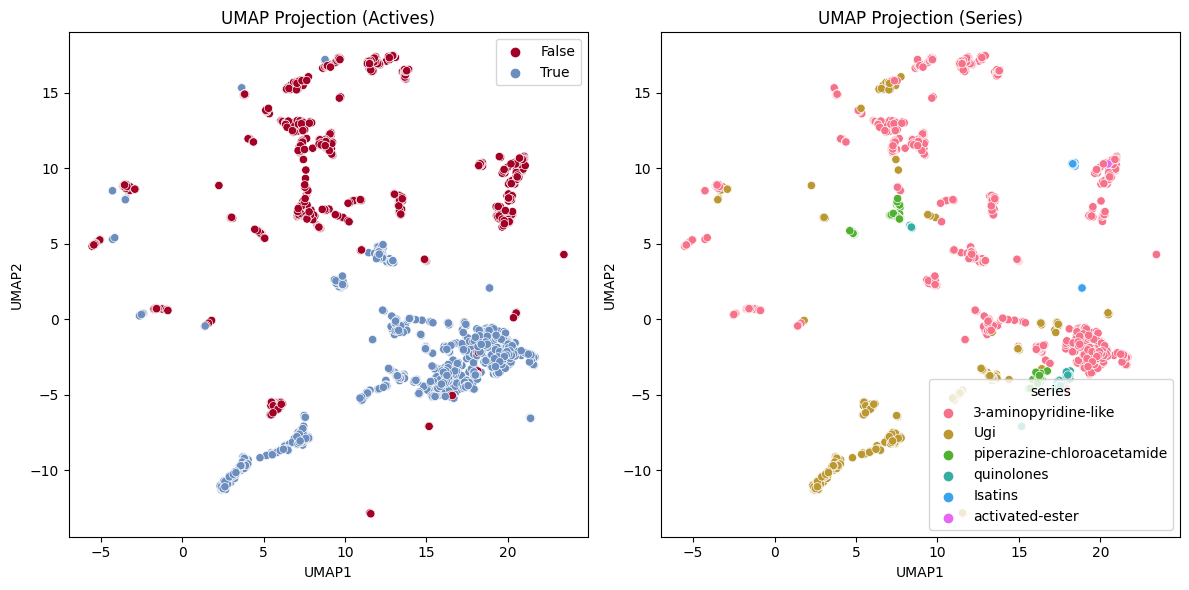

In [238]:
umap_model = best_model.named_steps['umap']
train_embedding = umap_model.transform(train_fps)

def plot_embedding(embedding, labels, title):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels)
    plt.title(title)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

# Visualize the UMAP embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_embedding(train_embedding, train_labels, 'UMAP Projection (Actives)')

plt.subplot(1, 2, 2)
plot_embedding(train_embedding, data['series'], 'UMAP Projection (Series)')

plt.tight_layout()
plt.savefig('figures/ch07/umap_projections.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/umap_projections.pdf', bbox_inches='tight', dpi=600);

## 2️⃣ Clustering: Curating Diverse Compound Libraries

In [5]:
# Load the data
file_path = 'CH07/data/raw/CH07_activity_data.csv'
data = pd.read_csv(file_path)

### Combinatorial Libraries

#### Combinatorial Library Design

In [7]:
from rdkit.Chem.Scaffolds import MurckoScaffold

cores, frags = [], []
data['mols'] = data['SMILES'].apply(Chem.MolFromSmiles)
for mol in data['mols']:
    if mol is None: continue

    # Get Murcko scaffold (core) of the molecule
    bms = MurckoScaffold.GetScaffoldForMol(mol)
    core = Chem.ReplaceSidechains(mol, bms)

    # Get fragments (rgroups) by replacing the core in the molecule
    rgroups = Chem.ReplaceCore(mol, bms)
    
    if core is None: continue
    cores.append(Chem.MolToSmiles(core))

    if rgroups:
        frags.extend(Chem.MolToSmiles(rgroups).split('.'))

In [19]:
#Annotation: For only generating a few thousand compounds, highly unlikely to generate any repeats. Would want to modify code if generating hundreds of thousands or more.
import random

reaction_smirks = "[*:0][#0].[#0][*:1]>>[*:0][*:1]"
rxn = AllChem.ReactionFromSmarts(reaction_smirks)
new_mols = []
EXPANSION_FACTOR = 5

# Loop over each scaffold
for core_smi in cores:
    for _ in range(EXPANSION_FACTOR):
        while "[*]" in core_smi:
            # Select a random fragment
            random_index = random.randint(0, len(frags)-1)

            # Use the reaction SMARTS to run a reaction
            products = rxn.RunReactants([
                Chem.MolFromSmiles(core_smi),
                Chem.MolFromSmiles(frags[random_index])
            ])
            
            # If no product is formed, continue with the next iteration
            if len(products)==0: continue
            # Select a random product
            product_index = random.randint(0, len(products)-1)
            core_smi = Chem.MolToSmiles(products[product_index][0])

        mol = Chem.MolFromSmiles(core_smi)
        if mol:
            AllChem.Compute2DCoords(mol)
            new_mols.append(mol)

#### Retrosynthetic Approach

In [30]:
from rdkit.Chem import BRICS

frags = set([])
for mol in data['mols']:
    if mol is None: continue
    # Decompose molecules into BRICS fragments and store unique fragments
    fragments = BRICS.BRICSDecompose(mol)
    frags.update(fragments)

frag_mols = []
for frag in frags:
    frag_mol = Chem.MolFromSmiles(frag)
    if frag_mol:
        AllChem.Compute2DCoords(frag_mol)
        frag_mols.append(frag_mol)

new_mols = []
# Build new molecules from the BRICS fragments with maximum depth of 1
for mol in BRICS.BRICSBuild(frag_mols, maxDepth=1):
    if len(new_mols) > 10000:
        break
    try:
        Chem.SanitizeMol(mol)
        AllChem.Compute2DCoords(mol)
        new_mols.append(mol)
    except:
        continue    # Skip molecules that cannot be sanitized

### Cluster-based Compound Selection

#### Hierarchical Clustering: Agglomerative Clustering

**Code for Figure 7.10.** Dendrogram of agglomerative clusterings fit with different levels of truncation.

In [47]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from rdkit.Chem import rdFingerprintGenerator

# Function to compute Ward's method agglomerative clustering and plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Convert RDKit molecules to Morgan fingerprints
def molecules_to_fingerprints(mols, radius=2, nBits=2048):
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5) # Daylight FP approximation
    fingerprints = [rdkit_gen.GetFingerprint(mol) for mol in mols]
    
    np_fps = []
    for fp in fingerprints:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fps.append(arr)
    return np.array(np_fps), fingerprints

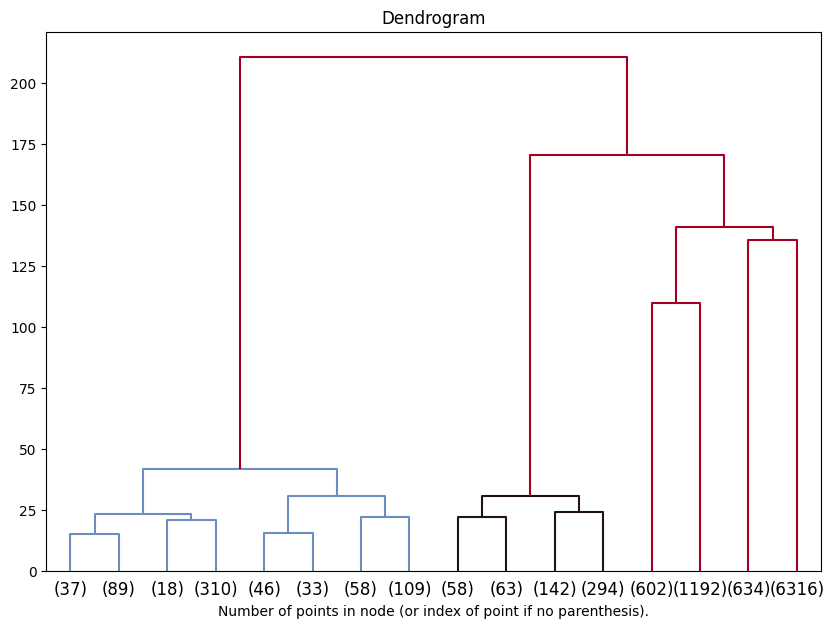

In [46]:
fps, rdkit_fps = molecules_to_fingerprints(new_mols)

# Apply agglomerative clustering with Ward's method
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(fps)

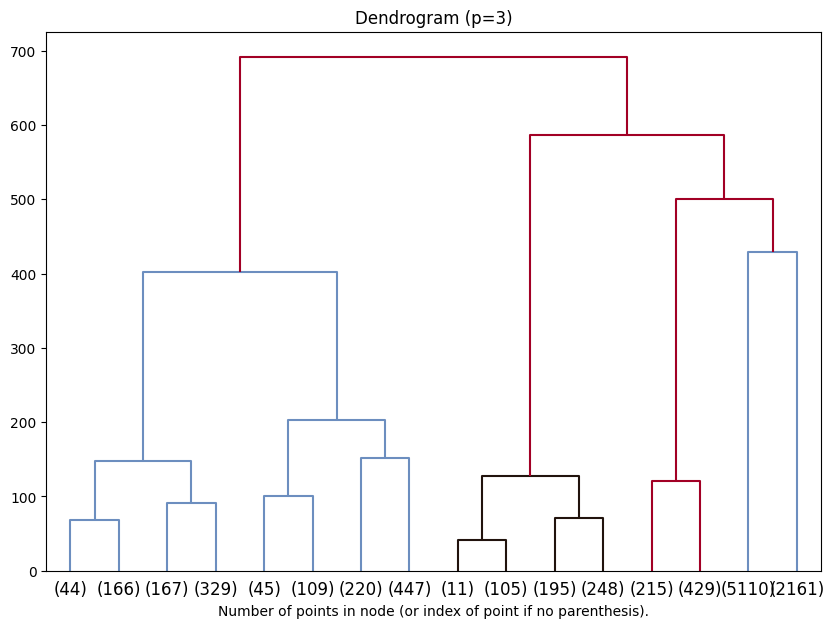

In [90]:
# Plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (p=3)")
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.tight_layout()
plt.savefig('figures/ch07/dendrogram_p3.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/dendrogram_p3.pdf', bbox_inches='tight', dpi=600);

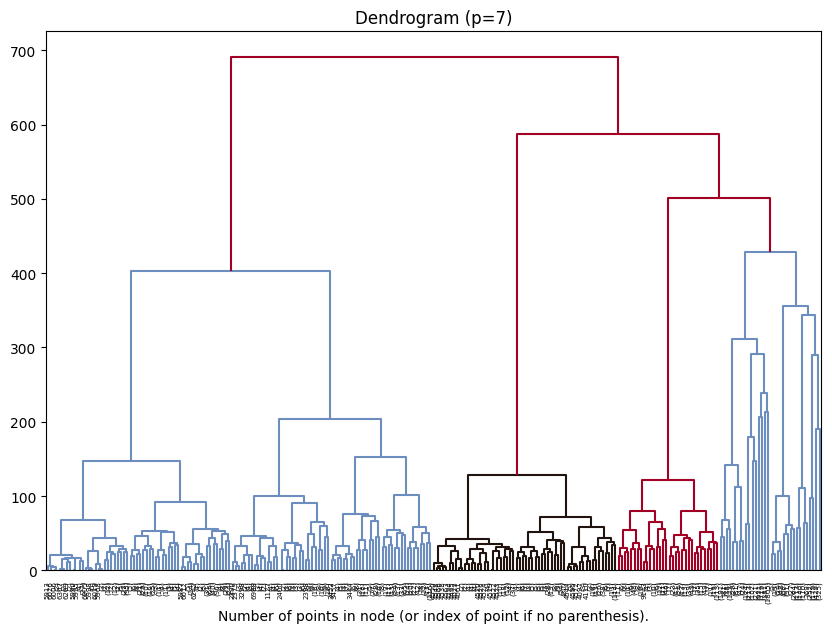

In [89]:
# Plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (p=7)")
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('figures/ch07/dendrogram_p7.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/dendrogram_p7.pdf', bbox_inches='tight', dpi=600);

In [75]:
# Redo clustering with 16 clusters based on visual inspection
agg_model = AgglomerativeClustering(n_clusters=16, linkage='ward')
agg_model.fit(fps)
agg_clusters = [np.where(agg_model.labels_ == i)[0].tolist() for i in np.unique(agg_model.labels_)]

In [76]:
def sample_from_clusters(fps, clusters, n_samples=3):
    sampled_mols = []
    cluster_centers = []

    for cluster in clusters:
        if len(cluster) < n_samples:
            sampled_mols.extend(cluster)
        else:
            cluster_fps = [fps[i] for i in cluster]
            cluster_center = np.mean(cluster_fps, axis=0).reshape(1, -1)
            cluster_centers.append(cluster_center)

            distances = cdist(cluster_fps, cluster_center, metric='euclidean')
            closest_indices = np.argsort(distances.flatten())[:n_samples]
            sampled_mols.extend([cluster[i] for i in closest_indices])

    return sampled_mols

agg_sampled_indices = sample_from_clusters(fps, agg_clusters)
agg_sampled_molecules = [new_mols[i] for i in agg_sampled_indices]

#### Prototype-based Clustering: Taylor-Butina Clustering

In [62]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform

 # Perform Taylor-Butina clustering
def butina_clustering(fingerprints, cutoff=0.2):
    dists = []
    nfps = len(fingerprints)
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        dists.extend([1 - x for x in sims])
    cluster_data = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    return cluster_data

In [63]:
fps, rdkit_fps = molecules_to_fingerprints(new_mols)

In [64]:
# Determine the optimal number of clusters using the CH Index
ch_scores = []
silhouette_scores = []
db_scores = []
cutoffs = np.arange(0.0, 1.0, 0.2)
cutoffs_to_clusters = {}

for cutoff_ in cutoffs:
    clusters = butina_clustering(rdkit_fps, cutoff=cutoff_)
    cutoffs_to_clusters[cutoff_] = clusters
    cluster_labels = np.zeros(len(new_mols))
    for cluster_id, cluster in enumerate(clusters):
        for mol_id in cluster:
            cluster_labels[mol_id] = cluster_id
    ch_scores.append(calinski_harabasz_score(fps, cluster_labels))
    silhouette_scores.append(silhouette_score(fps, cluster_labels))
    db_scores.append(davies_bouldin_score(fps, cluster_labels))


**Code for Figure 7.11** Distribution of number of molecules in each cluster at different neighbor thresholds.

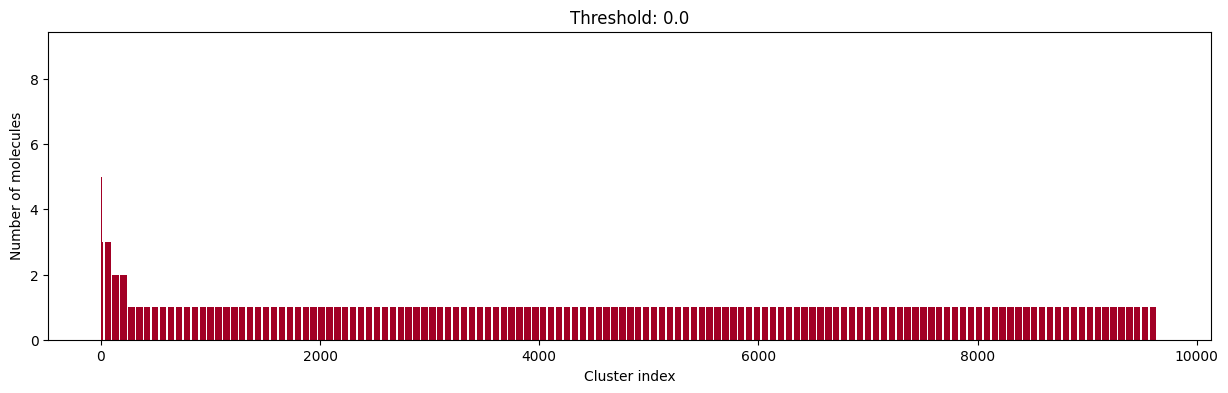

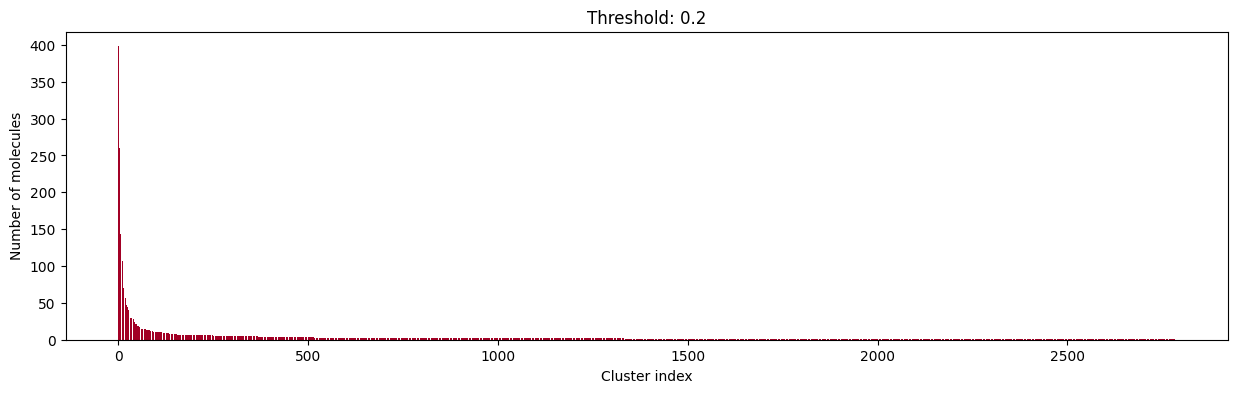

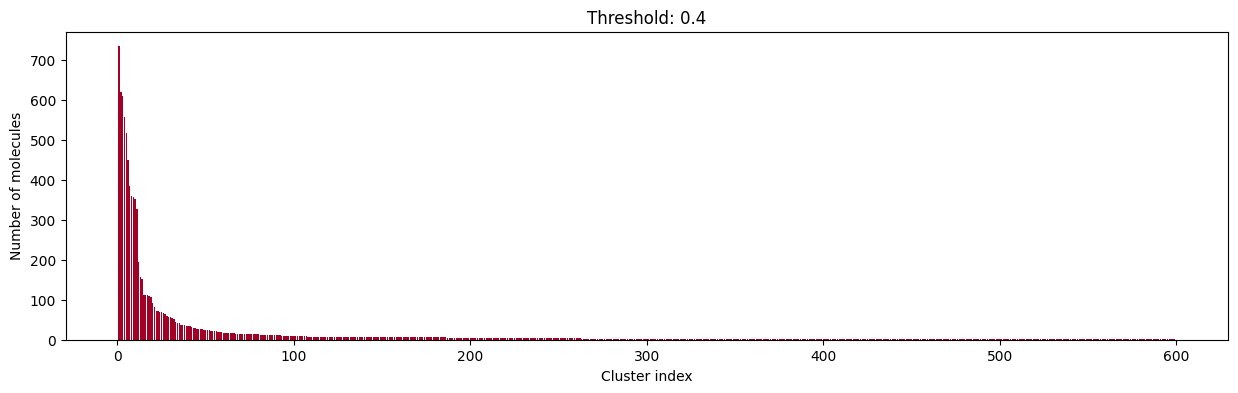

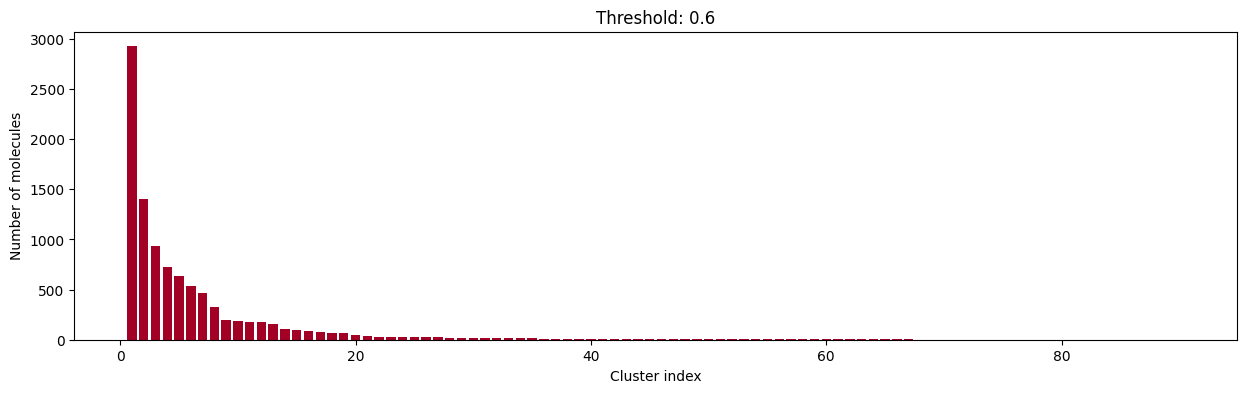

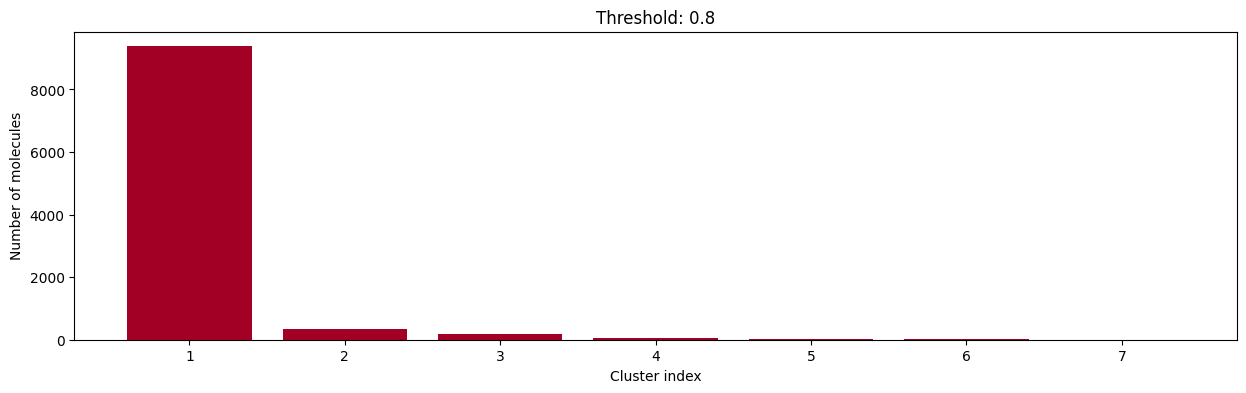

In [70]:
# Too many singletons or all in one cluster == bad. How
for cutoff_, clusters in cutoffs_to_clusters.items():
    clusters = sorted(clusters, key=len, reverse=True)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff_:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)


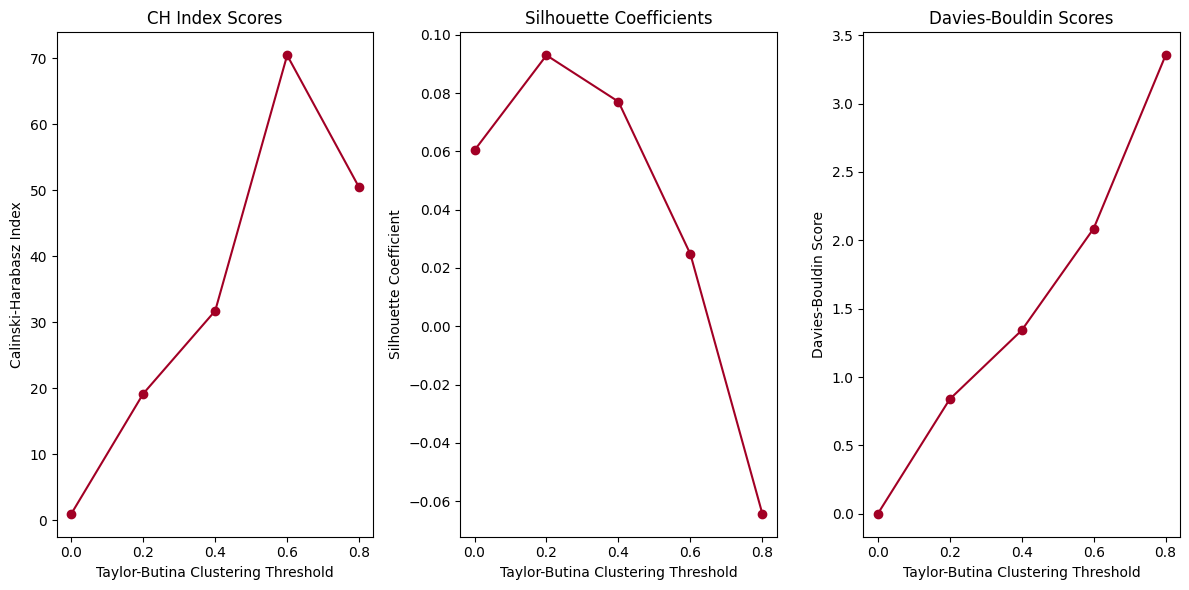

In [243]:
plt.figure(figsize=(12, 6))

# CH Index plot
plt.subplot(1, 3, 1)
plt.plot(cutoffs, ch_scores, marker='o')
plt.xlabel('Taylor-Butina Clustering Threshold')
plt.ylabel('Calinski-Harabasz Index')
plt.title('CH Index Scores')

# Silhouette coefficient plot
plt.subplot(1, 3, 2)
plt.plot(cutoffs, silhouette_scores, marker='o')
plt.xlabel('Taylor-Butina Clustering Threshold')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficients')

# Davies-Bouldin score plot
plt.subplot(1, 3, 3)
plt.plot(cutoffs, db_scores, marker='o')
plt.xlabel('Taylor-Butina Clustering Threshold')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Scores')

plt.tight_layout()

In [78]:
#optimal_cutoff = cutoffs[np.argmax(ch_scores)]
#print(f"Optimal cut-off: {optimal_cutoff}")

optimal_cutoff = 0.4
clusters = cutoffs_to_clusters[optimal_cutoff]
cluster_labels = np.zeros(len(new_mols))
for cluster_id, cluster in enumerate(clusters):
    for mol_id in cluster:
        cluster_labels[mol_id] = cluster_id

In [79]:
# Create a new subset of molecules by sampling a few compounds from each cluster
from scipy.spatial.distance import cdist

def sample_from_clusters(fps, clusters, n_samples=3):
    sampled_mols = []
    cluster_centers = []

    for cluster in clusters:
        if len(cluster) < n_samples:
            sampled_mols.extend(cluster)
        else:
            cluster_fps = [fps[i] for i in cluster]
            cluster_center = np.mean(cluster_fps, axis=0).reshape(1, -1)
            cluster_centers.append(cluster_center)

            distances = cdist(cluster_fps, cluster_center, metric='euclidean')
            closest_indices = np.argsort(distances.flatten())[:n_samples]
            sampled_mols.extend([cluster[i] for i in closest_indices])

    return sampled_mols

butina_sampled_indices = sample_from_clusters(fps, clusters)
butina_sampled_molecules = [new_mols[i] for i in butina_sampled_indices]


### Comparing Clustering Methods

In [80]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt

# Calculate Tanimoto distance matrix
def calculate_tanimoto_distances(fingerprints):
    n = len(fingerprints)
    tanimoto_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            tanimoto_distances[i, j] = 1 - DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            tanimoto_distances[j, i] = tanimoto_distances[i, j]
    return tanimoto_distances

# Calculate the diversity of the sampled sets based on pairwise Tanimoto similarity
def calculate_diversity(sampled_indices, fingerprints):
    sampled_fps = [fingerprints[i] for i in sampled_indices]
    tanimoto_distances = calculate_tanimoto_distances(sampled_fps)
    avg_tanimoto_similarity = 1 - np.mean(tanimoto_distances)
    return avg_tanimoto_similarity

agg_diversity = calculate_diversity(agg_sampled_indices, rdkit_fps)
butina_diversity = calculate_diversity(butina_sampled_indices, rdkit_fps)

print(f"Agglomerative clustering sampled set diversity (lower is better): {agg_diversity}")
print(f"Taylor-Butina clustering sampled set diversity (lower is better): {butina_diversity}")

if agg_diversity < butina_diversity:
    print("The Agglomerative clustering sampled set is more diverse.")
else:
    print("The Taylor-Butina clustering sampled set is more diverse.")


Agglomerative clustering sampled set diversity (lower is better): 0.2908996343561364
Taylor-Butina clustering sampled set diversity (lower is better): 0.23645599873221257
The Taylor-Butina clustering sampled set is more diverse.


In [81]:
# Calculate the redundancy of the sampled sets based on pairwise Tanimoto similarity
def calculate_redundancy(sampled_indices, fingerprints, threshold=0.85):
    sampled_fps = [fingerprints[i] for i in sampled_indices]
    tanimoto_matrix = np.zeros((len(sampled_fps), len(sampled_fps)))
    for i, fp1 in enumerate(sampled_fps):
        for j, fp2 in enumerate(sampled_fps):
            if i != j:
                similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
                tanimoto_matrix[i, j] = similarity
    redundant_pairs = np.where(tanimoto_matrix > threshold)
    num_redundant_pairs = len(redundant_pairs[0])
    num_unique_pairs = len(sampled_fps) * (len(sampled_fps) - 1) / 2
    redundancy_ratio = num_redundant_pairs / num_unique_pairs
    return redundancy_ratio

agg_redundancy = calculate_redundancy(agg_sampled_indices, rdkit_fps)
butina_redundancy = calculate_redundancy(butina_sampled_indices, rdkit_fps)

print(f"Agglomerative clustering sampled set redundancy ratio (lower is better): {agg_redundancy}")
print(f"Taylor-Butina clustering sampled set redundancy ratio (lower is better): {butina_redundancy}")

if agg_redundancy < butina_redundancy:
    print("The Agglomerative clustering sampled set is less redundant.")
else:
    print("The Taylor-Butina clustering sampled set is less redundant.")


Agglomerative clustering sampled set redundancy ratio (lower is better): 0.07624113475177305
Taylor-Butina clustering sampled set redundancy ratio (lower is better): 0.0009972406666621542
The Taylor-Butina clustering sampled set is less redundant.


In [83]:
len(butina_sampled_indices)

1332

## 3️⃣ Density Estimation: Fragment-based Drug Discovery

### Density Estimation

In [96]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [97]:
# Adapted from: https://www.statsmodels.org/devel/examples/notebooks/generated/kernel_density.html
#Location, scale and weight for the two distributions
dist1_loc, dist1_scale, weight1 = -1, 0.5, 0.25
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75

# Sample from a mixture of distributions
obs_dist = mixture_rvs(
    prob=[weight1, weight2],
    size=250,
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
)

In [98]:
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()  # Estimate the densities

**Code for Figure 7.14.** Comparison of histogram and kernel density estimation on a bimodal distribution

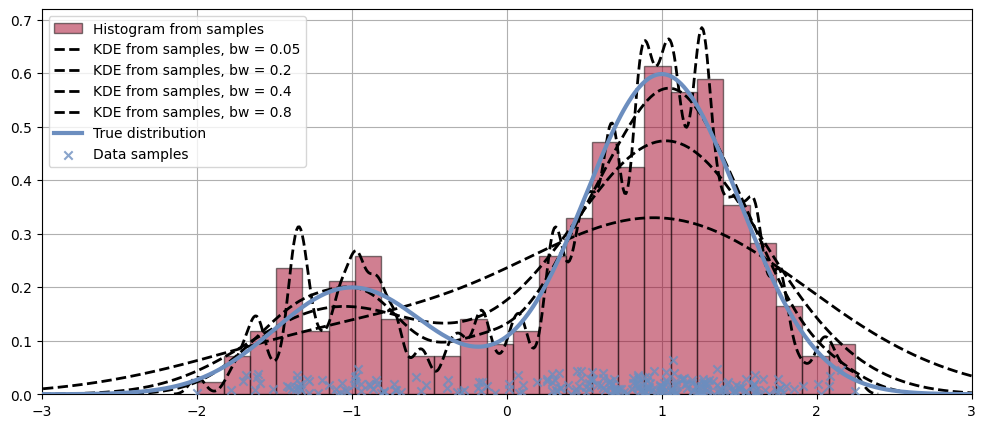

In [108]:
#Adapted from https://www.statsmodels.org/devel/examples/notebooks/generated/kernel_density.html#Kernel-Density-Estimation

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histogram
ax.hist(
    obs_dist,
    bins=25,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    density=True,
    alpha=0.5,
)

# Plot the KDE for various bandwidths
for bandwidth in [0.05, 0.2, 0.4, 0.8]:
    kde.fit(bw=bandwidth)  # Estimate the densities
    ax.plot(
        kde.support,
        kde.density,
        "--",
        lw=2,
        color="k",
        zorder=10,
        label="KDE from samples, bw = {}".format(round(bandwidth, 2)),
    )

# Plot the true distribution
true_values = (
    stats.norm.pdf(loc=dist1_loc, scale=dist1_scale, x=kde.support) * weight1
    + stats.norm.pdf(loc=dist2_loc, scale=dist2_scale, x=kde.support) * weight2
)
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="#6C8EBF",
    zorder=20,
    label="Data samples",
    alpha=0.8,
)

ax.legend(loc="best")
ax.set_xlim([-3, 3])
ax.grid(True, zorder=-5)

plt.savefig('figures/ch07/kde_example.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/kde_example.pdf', bbox_inches='tight', dpi=600);

### FRESCO Pipeline

Using the Fresco demo as a guide, we will discuss each step with attention to the internals that focus on pharmacophore modeling and density estimation. Much of the following code is adapted from FRESCO's GitHub repository: https://github.com/wjm41/fresco/tree/master

In [115]:
from rdkit.Chem import PandasTools
import os
from tqdm import tqdm
from rdkit.Chem import ChemicalFeatures, MolToSmiles
from rdkit.RDPaths import RDDataDir

sdfFile = 'CH07/data/raw/mpro_frags.sdf'
df_fragments = PandasTools.LoadSDF(sdfFile, idName='name', smilesName='SMILES', molColName='mol')

In [158]:
def compute_pcore_data(mol, mol_id=0):
    """
    Compute pharmacophoric core (pcore) data for a given molecule.
    
    Parameters:
    - mol: RDKit molecule object
    - mol_id: Identifier for the molecule

    Returns:
    - DataFrame containing pcore information
    """
    # Define pharmacophoric cores of interest
    pcores_of_interest = ['Donor', 'Acceptor', 'Aromatic']

    # Load feature definition file
    fdefFile = os.path.join(RDDataDir, 'BaseFeatures.fdef')
    featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

    # Get atom coordinates and pharmacophore features
    atom_coordinates = mol.GetConformer().GetPositions()
    pharmacophore_features = featFactory.GetFeaturesForMol(mol)

    # Collect DataFrame rows
    rows = []
    for pcore in pharmacophore_features:
        pharmacophore_name = pcore.GetFamily()

        if pharmacophore_name in pcores_of_interest:
            atom_ids = pcore.GetAtomIds()
            xyz = np.mean([atom_coordinates[id] for id in atom_ids], axis=0)
            rows.append({
                'pcore': pharmacophore_name,
                'smiles': MolToSmiles(mol),
                'mol_id': mol_id,
                'coord_x': [xyz[0]],
                'coord_y': [xyz[1]],
                'coord_z': [xyz[2]],
            })
    return pd.DataFrame(rows)

In [138]:
mols = df_fragments['mol'].values
dfs = []
for mol_id, mol in tqdm(enumerate(mols), total=len(mols)):
    dfs.append(compute_pcore_data(mol, mol_id))
pcore_df = pd.concat(dfs)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 64.46it/s]


In [139]:
pcore_df.head()

,pcore,smiles,mol_id,coord_x,coord_y,coord_z
0,Donor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,8.8612,5.1249,22.8984
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.0863,-1.0956,24.5273
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.9905,-0.3540,22.5499
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,11.1835,6.2738,23.3719
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,9.9526,5.4586,25.2863


In [140]:
def calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(df_of_frag_ensemble_pcores, pcore_a, pcore_b):
    """
    Calculate pairwise distances between two specified pharmacophores within a fragment ensemble.

    Parameters:
    - df_of_frag_ensemble_pcores: DataFrame containing pharmacophoric data for fragment ensemble
    - pcore_a: Name of the first pharmacophore
    - pcore_b: Name of the second pharmacophore

    Returns:
    - A NumPy array of pairwise distances between the specified pharmacophores
    """
    # Filter DataFrame for the specified pharmacophores
    df_pcore_a = df_of_frag_ensemble_pcores.query('pcore == @pcore_a')
    df_pcore_b = df_of_frag_ensemble_pcores.query('pcore == @pcore_b')
    
    unique_smiles_a = df_pcore_a['smiles'].unique()
    # Initialize list to store distances
    distances_for_all_pairs = []
    
    for smile in unique_smiles_a:
        # Coordinates of pcore_a in the current fragment
        coords_a = df_pcore_a[df_pcore_a['smiles'] == smile][['coord_x', 'coord_y', 'coord_z']].to_numpy()
        
        # Coordinates of pcore_b in different fragments (don't count distances within the same fragment)
        coords_b = df_pcore_b[df_pcore_b['smiles'] != smile][['coord_x', 'coord_y', 'coord_z']].to_numpy()
        
        if coords_b.size == 0:
            continue  # Skip if there are no pcore_b in different fragments
        
        # Calculate  and store pairwise distances
        delta_coords = coords_a[:, np.newaxis, :] - coords_b[np.newaxis, :, :]
        distances_for_this_pair = np.linalg.norm(delta_coords, axis=2).flatten()
        distances_for_all_pairs.append(distances_for_this_pair)

    return np.hstack(distances_for_all_pairs)

In [142]:
interesting_pcores = [
    'Donor-Aromatic', 'Aromatic-Acceptor', 'Aromatic-Aromatic',
    'Donor-Donor', 'Donor-Acceptor', 'Acceptor-Acceptor'
]
frag_pcore_histogram = {}
frag_pcore_weight = {}
for pcore_pair in interesting_pcores:
    core_a, core_b = pcore_pair.split('-')
    frag_pcore_histogram[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(pcore_df, core_a, core_b)

In [143]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def fit_sklearn_pair_kde(data):
    params = {'bandwidth': np.logspace(-3, 3, 50)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-4), params)
    grid.fit(data.reshape(-1, 1))
    kde = grid.best_estimator_
    return kde

fresco_kdes = {}
for pcore_pair in interesting_pcores:
    fresco_kdes[pcore_pair] = fit_sklearn_pair_kde(frag_pcore_histogram[pcore_pair])

In [146]:
fresco_kdes

{'Donor-Aromatic': KernelDensity(bandwidth=0.868511373751352, rtol=0.0001),
 'Aromatic-Acceptor': KernelDensity(bandwidth=0.655128556859551, rtol=0.0001),
 'Aromatic-Aromatic': KernelDensity(bandwidth=0.1206792640639329, rtol=0.0001),
 'Donor-Donor': KernelDensity(bandwidth=0.0071968567300115215, rtol=0.0001),
 'Donor-Acceptor': KernelDensity(bandwidth=0.49417133613238334, rtol=0.0001),
 'Acceptor-Acceptor': KernelDensity(bandwidth=0.016768329368110083, rtol=0.0001)}

**Code for Figure 7.15** Fitted density estimates of pharmacophore pair distributions.

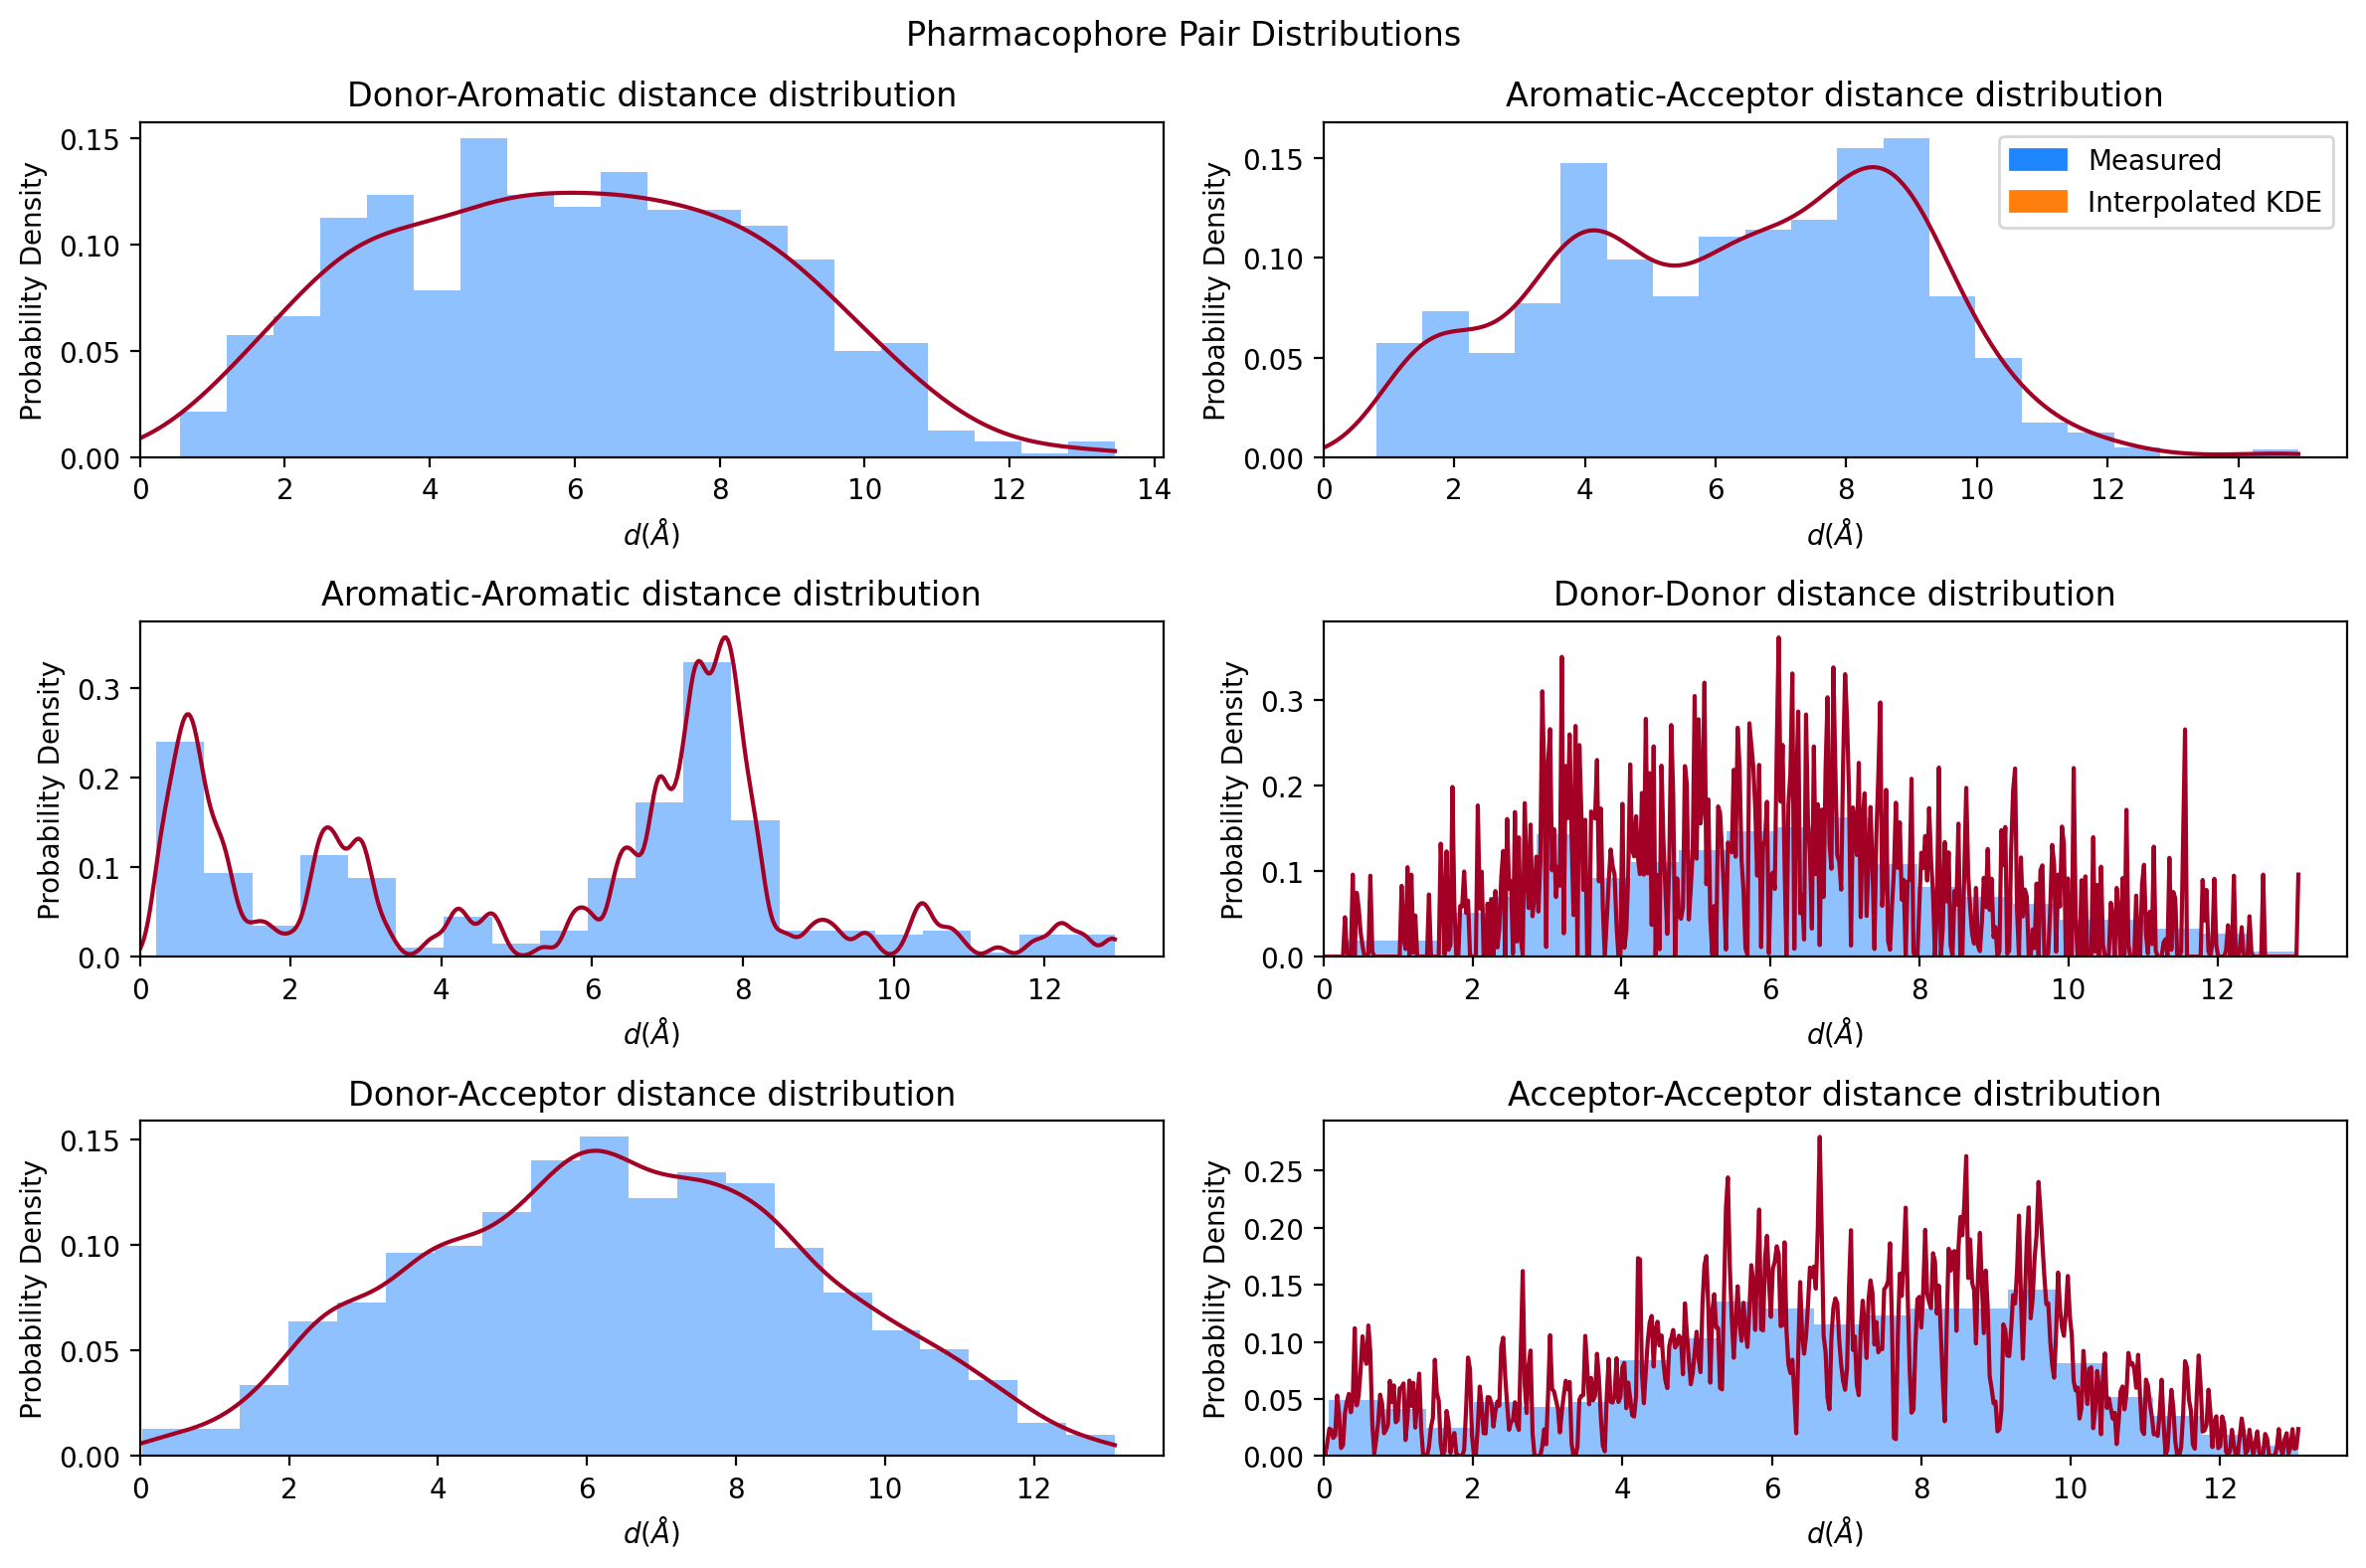

In [152]:
from matplotlib.patches import Rectangle

CMAP = plt.get_cmap("tab10")

def plot_kdes(kde_dicts, frag_2body_dict, interesting_pcores, nx=500, n_bins=20, title=''):

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,8), dpi=200)
    fig.suptitle(title)

    axs = axs.reshape(-1)
    for i, pcore_combo in enumerate(interesting_pcores):
        x = np.linspace(0, np.amax(frag_2body_dict[pcore_combo]), nx)
        kde_pair = kde_dicts[pcore_combo]
        axs[i].set_title('{} distance distribution'.format(
            pcore_combo))
        axs[i].hist(frag_2body_dict[pcore_combo], bins=n_bins,
                    alpha=0.5, density=True, color='#1E85FC')
        axs[i].plot(x, np.exp(kde_pair.score_samples(x.reshape(-1, 1))))
        axs[i].set_xlim(left=0)
        axs[i].set_ylabel('Probability Density')
        axs[i].set_xlabel(r'$d (\AA)$')
    legend_elements = [Rectangle((0, 0), 1, 1, color='#1E85FC', label='Measured'),
                    Rectangle((0, 0), 1, 1,  color=CMAP(1), label='Interpolated KDE')]
    axs[1].legend(handles=legend_elements, loc='upper right')
    fig.tight_layout()    
    return fig

fig_distributions = plot_kdes(
    fresco_kdes, frag_pcore_histogram, interesting_pcores, title='Pharmacophore Pair Distributions')

In [155]:
smiles = 'Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

0

In [159]:
def calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(df_of_pcores_for_single_ligand, pcore_a, pcore_b):
    """
    Calculate the pairwise distance between pharmacophores pcore_a and pcore_b in the same ligand.

    Parameters:
    - df: DataFrame containing pharmacophoric data for a single ligand
    - pcore_a: Name of the first pharmacophore
    - pcore_b: Name of the second pharmacophore

    Returns:
    - A NumPy array of pairwise distances between the specified pharmacophores
    """
    df_pcore_a = df_of_pcores_for_single_ligand.query('pcore == @pcore_a')
    coords_a = df_pcore_a[['coord_x', 'coord_y', 'coord_z']].to_numpy()
    df_pcore_b = df_of_pcores_for_single_ligand.query('pcore == @pcore_b')
    coords_b = df_pcore_b[['coord_x', 'coord_y', 'coord_z']].to_numpy()
  
    # If coordinates are missing then we can't calculate distances
    if len(coords_b) > 0:
        delta_coords = coords_a[:, np.newaxis] - coords_b
        distances = np.linalg.norm(delta_coords, axis=2)
        return distances.flatten()

In [160]:
mol_pcore_df = compute_pcore_data(mol)
pair_distribution_for_this_ligand = {}
for pcore_pair in interesting_pcores:
    core_a, core_b = pcore_pair.split('-')
    pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
        mol_pcore_df, core_a, core_b)

In [165]:
def score_mol(kde_dict, pair_distribution, pcore_pairs):
    """
    Score a molecule based on its pharmacophoric pair distribution.

    Parameters:
    - kde_dict: Dictionary containing Kernel Density Estimations (KDE) for each pharmacophore pair
    - pair_distribution: Dictionary containing pairwise distances for the molecule
    - pcore_pairs: List of pharmacophore pairs

    Returns:
    - The score for the molecule
    """
    score_df = pd.DataFrame(columns=pcore_pairs)
    for pcore_combination in pcore_pairs:
        kde = kde_dict[pcore_combination]
        pcore_dist = pair_distribution[pcore_combination].reshape(-1, 1)
        pcore_score = np.max(kde.score_samples(pcore_dist.reshape(-1, 1)))
        score_df.at[0, pcore_combination] = pcore_score

    return np.nanmean(score_df[pcore_pairs].to_numpy().astype(float))

In [166]:
score_for_this_mol = score_mol(fresco_kdes, pair_distribution_for_this_ligand, interesting_pcores)

In [167]:
score_for_this_mol

-1.9877088275522128

In [171]:
unseen_mol_scores = []
for mol_id, mol in enumerate(butina_sampled_molecules):
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol_pcore_df = compute_pcore_data(mol, mol_id)
        pair_distribution = {
            pcore_pair: calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
                mol_pcore_df, *pcore_pair.split('-')
            )
            for pcore_pair in interesting_pcores
        }
        unseen_mol_scores.append(score_mol(fresco_kdes, pair_distribution, interesting_pcores))
    except:
        print(f"Error processing molecule {mol_id}: {e}")
        continue

[00:35:33] UFFTYPER: Unrecognized atom type: Au6+3 (2)
[00:36:36] UFFTYPER: Unrecognized atom type: Au6+3 (2)
[00:37:10] UFFTYPER: Unrecognized atom type: Au6+3 (2)
[00:37:21] UFFTYPER: Unrecognized atom type: Au6+3 (2)
[00:37:22] UFFTYPER: Unrecognized atom type: Au6+3 (2)
[00:37:22] UFFTYPER: Unrecognized atom type: Au6+3 (2)


In [174]:
sorted(unseen_mol_scores)[::-1]

[-1.642475314237787,
 -1.6575241361151882,
 -1.673098307415735,
 -1.723465734687596,
 -1.7343476931975765,
 -1.7386268398589195,
 -1.741613567765042,
 -1.7479973523278343,
 -1.7658344658066298,
 -1.7695277686184792,
 -1.772700569557448,
 -1.7760786885125928,
 -1.789280136804937,
 -1.799056979606917,
 -1.811098649022706,
 -1.816147088149564,
 -1.8169953466209066,
 -1.8191953567755375,
 -1.8193005056615483,
 -1.8283983654762686,
 -1.8376508954345692,
 -1.8591083028206878,
 -1.86157431898907,
 -1.8726369550278903,
 -1.8770455678841031,
 -1.8787744823717223,
 -1.884864817347043,
 -1.8915760147261682,
 -1.896030935426694,
 -1.9044678479617179,
 -1.9141273461365487,
 -1.9202598749562556,
 -1.9236616320710453,
 -1.9518134761155241,
 -1.9598611121536973,
 -1.9732706732166356,
 -1.9746306083353204,
 -1.985869674698493,
 -1.9890371262911601,
 -1.990394164559229,
 -1.993185467346935,
 -2.0010549412997474,
 -2.0012979301930347,
 -2.002128151335979,
 -2.0079843848192773,
 -2.01071308366927,
 -2.015

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import Draw
import py3Dmol

smiles = 'C1=CC2=C(C=C1)C=NC=C2NC(=O)[C@H]3C4=C(OCC3)C=CC(=C4)Cl'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())

# Compute 3D coordinates
AllChem.UFFOptimizeMolecule(mol)

# Get the pharmacophoric features
hbd_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() > 0]  # Hydrogen bond donors
hba_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7 or (atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 0)]  # Hydrogen bond acceptors
aromatic_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIsAromatic()]  # Aromatic atoms

atom_colors = {}
for idx in hbd_atoms:
    atom_colors[idx] = (1, 0, 0)  # Red for HBD
for idx in hba_atoms:
    atom_colors[idx] = (0, 0, 1)  # Blue for HBA
for idx in aromatic_atoms:
    atom_colors[idx] = (0, 1, 0)  # Green for Aromatics

# Generate 3D coordinates for visualization
def mol_to_3Dview(mol, atom_colors=None):
    mol_block = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(mol_block, 'mol')
    viewer.setStyle({'stick': {}})
    if atom_colors:
        for atom_idx, color in atom_colors.items():
            viewer.setStyle({'model': -1, 'serial': atom_idx + 1}, {'stick': {'colorscheme': {'prop': 'elem', 'map': [[0, 'black'], [1, 'red'], [2, 'blue'], [3, 'green']], 'radius': 0.5}}})
            viewer.addSphere({'center': {'x': mol.GetConformer().GetAtomPosition(atom_idx).x,
                                         'y': mol.GetConformer().GetAtomPosition(atom_idx).y,
                                         'z': mol.GetConformer().GetAtomPosition(atom_idx).z},
                              'radius': 0.5, 'color': f'rgb({color[0]*255},{color[1]*255},{color[2]*255})', 'opacity': 0.6})
    viewer.zoomTo()
    return viewer

viewer = mol_to_3Dview(mol, atom_colors)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.